<h1>The Political Role of COVID-19</h1>

Group 3: Justin Deutsch, Djustin8; Emily Lawson, emily03; Matthew Pinho, mpinho16

The COVID-19 pandemic has people flooding the internet with updates, facts, and opinions but peoples opinions can differ, change over time, align with their political parties or none of the above creating a lot of confusion. Now is not the time for indecisiveness, debate, and disagreement. The economy, people’s livelihoods, and most importantly people’s lives are at stake. 

Therefore, Group 3 will evaluate, and analyze the growth over time of the political relevance of COVID-19 as well as compare and contrast the sentiments and the perspective of the major political figures on the pandemic of both major political parties.

We want to know how have sentiments changed about the pandemic crisis over time generally and party-wise? How has the vocabulary changed? How different do Democrats and Republicans think? As well as how loyal are their members to their party’s viewpoints?

Our hypothesis: We hypothesize that the sentiments will show everyone has taken it more seriously over time, but party-wise Republicans keep a more positive outlook and Democrats are more negative. We also believe that individual’s opinions will be loyal or align with their party’s.


## Collecting the Data

Our end goal is to collect all tweets on around perhaps 20 different politicians (10 from each party) from the beginning of January this year. But right we have only collected tweets from 6 politicians (3 from each party) from the beginning of March. For now, we are working with a small sample and a small time interval because we want only to test our algorithms for efficiency while also thinking about what exactly to do with our data: how we want to visualize it/present it, how (if we need to) we can change our approach, etc.

### Authorization
The authorization is basic, except we have the parameter `wait_on_rate_limit=True`, which automatically and conveniently does the process on waiting on Tweepy's API rate limits.

In [3]:
import pandas as pd
import json
from pprint import pprint
import tweepy

def loadKeys(key_file):
    with open('keys.json') as f:
        key_dict = json.load(f)
    return key_dict['api_key'], key_dict['api_secret'], key_dict['token'], key_dict['token_secret']

KEY_FILE = 'keys.json'
[api_key, api_secret, token, token_secret] = loadKeys(KEY_FILE)
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(token, token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Defining functions for collecting data
Below, we define two functions. The second one `getTweetsSince` is the one that does the job of collecting data using Tweepy, given a Twitter username and a `since_id`, the parameter for the date after which tweets are collected. This function essentially does the same job as Tweepy's `Cursor` function, which we were trying to use initially. However, we kept running into problems using it to collect data, because the `Cursor` function somehow was completely unresponsive to the `since_id` parameter.

Other than that, our `getTweetsSince` function uses an auxiliary function, `appendTweet`, which is essentially responsible for properly appending a tweet's information we think is important (e.g., the text, post date, whether or not it is a retweet) into our data frame.

In [1]:
def appendTweet(data,tweet):
    row = [tweet.user.name,tweet.user.screen_name,tweet.full_text,
           tweet.created_at,tweet.favorite_count,tweet.retweet_count,hasattr(tweet, 'retweeted_status'),
           'media' in tweet.entities]
    row_series = pd.Series(row, index = data.columns)
    data = data.append(row_series, ignore_index=True)
    return data

def getTweetsSince(since_id,username,data):
    page = 1
    while True:
        tweets = api.user_timeline(id=username,page=page,tweet_mode='extended')
        if tweets and str(tweets[-1].created_at) > since_id:
            for tweet in tweets:
                data = appendTweet(data,tweet)
        else:
            return data
        page += 1

### Collecting data
Now that the important functions are defined, all that is left to do is iterate over a list of politicians' Twitter usernames, and call `getTweetsSince` on each username. And this process at its conclusion produces a big data frame on all of the tweets from all of the given politicans since the given date. And the end of this entire step, the data is stored into a .csv file to be passed on for analysis.

In [ ]:
#list of politician usernames
politicians = ["@realDonaldTrump","@GovRonDeSantis","@marcorubio","@JoeBiden","@NYGovCuomo","@BernieSanders"]

#Columns are the tweet data we are intersted in (for the moment)
data = pd.DataFrame(columns=["Name","Username","Text","Created",
                                 "Favorite Count","Retweet Count","Retweeted","Media Attached"])

since_id = '2020-03-01' #tweets will be collected from the beginning of March
for username in politicians:
    data = getTweetsSince(since_id,username,data)
data.to_csv('six_politicians')



## Processing the Data

In this step, we put the data in the .csv file from the previous step back into a data frame.

### Loading Data

In [15]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from itertools import groupby

In [16]:
# Loading in the data from FILE
DATA_FILE = 'six_politicians'

In [17]:
# Reading the data 
df = pd.read_csv(DATA_FILE, index_col=0)

# Converting the data Created to a datetime object
df['Created'] = pd.to_datetime(df['Created'])

df.shape, df.dtypes

((2498, 8),
 Name                      object
 Username                  object
 Text                      object
 Created           datetime64[ns]
 Favorite Count             int64
 Retweet Count              int64
 Retweeted                   bool
 Media Attached              bool
 dtype: object)

In [18]:
# Displaying the list of people and their twitter handles
names_handles = zip(df['Name'].unique().tolist(), df['Username'].unique().tolist())

print(f"{'Name':>20} ---> Twitter Handle")
print('----------------------------------------')
for n, h in names_handles:
    print(f'{n:>20} ---> {h}')

                Name ---> Twitter Handle
----------------------------------------
     Donald J. Trump ---> realDonaldTrump
        Ron DeSantis ---> GovRonDeSantis
         Marco Rubio ---> marcorubio
           Joe Biden ---> JoeBiden
        Andrew Cuomo ---> NYGovCuomo
      Bernie Sanders ---> BernieSanders


In [19]:
df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False
1,Donald J. Trump,realDonaldTrump,White House News Conference at 5:45. Thank you!,2020-04-19 20:13:28,62328,12827,False,False
2,Donald J. Trump,realDonaldTrump,Thank you to my boy! https://t.co/GAFe1AdZpt,2020-04-19 19:38:09,70865,25015,False,False
3,Donald J. Trump,realDonaldTrump,“On February 19th there was a Democratic Debat...,2020-04-19 19:18:05,63158,19546,False,False
4,Donald J. Trump,realDonaldTrump,Great book by @SenatorTimScott! https://t.co/9...,2020-04-19 19:15:28,20342,5419,False,False


In [20]:
df.tail()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
2493,Bernie Sanders,BernieSanders,I'm honored to receive the endorsement of Blac...,2020-03-01 14:59:47,23927,4135,False,False
2494,Bernie Sanders,BernieSanders,"RT @ChuyForCongress: ¡Nuestra Futuro, Nuestra ...",2020-03-01 14:52:13,0,470,False,False
2495,Bernie Sanders,BernieSanders,RT @ninaturner: “Obstacles don't have to stop ...,2020-03-01 14:05:03,0,1276,False,False
2496,Bernie Sanders,BernieSanders,I am once again asking for your financial supp...,2020-03-01 03:48:56,26138,3653,False,False
2497,Bernie Sanders,BernieSanders,RT @FaceTheNation: SUNDAY: Ahead of Super Tues...,2020-03-01 03:32:08,0,467,False,False


### Preprocessing

#### Removing Keywords

In [21]:
KEYWORD_FILE = 'covid_keywords.txt'

In [22]:
# Loading keywords
keywords = []

with open(KEYWORD_FILE, 'r') as f:
    line = f.readline()
    while line:
        keywords.append(line.strip().lower())
        line = f.readline()

len(keywords), keywords[:5]

(61, ['unemployment', 'front line', 'testing', 'health', 'public health'])

In [23]:
# Making keywords regex safe then filtering df by them
safe_keywords = [re.escape(word) for word in keywords]
clean_df = df[df['Text'].str.lower().str.contains('|'.join(safe_keywords))].copy()

df.shape, clean_df.shape

((2498, 8), (1174, 8))

## Analysis

### Count of Covid Tweets

In [24]:
# counts tweets per user
def count_tweets_per_user(df):
    counts = []
    
    for user in df['Username'].unique():
        counts.append((user, df[df['Username'] == user].shape[0]))
    
    return counts

In [25]:
from itertools import groupby

# counting tweets for each user before/after filtering by keywords
num_tweets_before_filtering = count_tweets_per_user(df)
num_tweets_after_filtering = count_tweets_per_user(clean_df)

# joining the two lists together 
num_tweets_before_after = num_tweets_before_filtering + num_tweets_after_filtering

# sorting by username so users' counts are next to each other, needed for groupby
num_tweets_before_after = sorted(num_tweets_before_after)

d = groupby(num_tweets_before_after, lambda x: x[0])
counts = []

for x in d:
    f = next(x[1])[1]
    s = next(x[1])[1]
    counts.append((x[0], max(f, s), min(f, s)))

counts

[('BernieSanders', 558, 250),
 ('GovRonDeSantis', 40, 16),
 ('JoeBiden', 500, 253),
 ('NYGovCuomo', 620, 407),
 ('marcorubio', 480, 161),
 ('realDonaldTrump', 300, 87)]

In [26]:
# Percent tweets that are covid related:
for entry in counts:
    print(f'{entry[0]}: {min(entry[1], entry[2]) / max(entry[1], entry[2]):.2%}')

BernieSanders: 44.80%
GovRonDeSantis: 40.00%
JoeBiden: 50.60%
NYGovCuomo: 65.65%
marcorubio: 33.54%
realDonaldTrump: 29.00%


### Word and Character Counts

In [27]:
clean_df['num_chars'] = clean_df['Text'].map(len)
clean_df['word_count'] = clean_df['Text'].map(lambda x: len(x.split()))     # this isn't robust against not,very,well,written,tweets
                                                                            # should change this to use regular expression or library 

In [28]:
clean_df[['num_chars', 'word_count']].describe()

,num_chars,word_count
count,1174.000000,1174.000000
mean,209.552811,33.672061
std,68.383854,11.937988
min,29.000000,3.000000
25%,144.000000,24.000000
50%,227.000000,36.000000
75%,273.000000,43.750000
max,333.000000,57.000000


### NLTK Sentiment Analysis
Our initial thoughts were that sentiment analysis may yield some results that could help distinguish if people's thoughts regarding COVID-19 changed over time. We have begun looking at general trends present in the sentiment scores of each tweet and done basic visualizations. With these results, we are unsure if the sentiment scores alone may provide the insight into the data that we are interested in. With the graphs presented here, we do not see much variety in the sentiment scores. It appears that the sentiments may be slightly biased towards having compound sentiments.

Potential causes for this may be the VADER sentiment analysis algorithm itself in conjunction with the preprocessing done on the data. Using a bag of words approach, VADER may not be cognizant of many of the terms foudn in these tweets since the topic is so recent; the words may not be present in the bag used. Additionally, the preprocessing could hinder the results. Further work must be done in how we preprocess and clean the text. 

Sentiment analysis may also not show the results that we are looking for. Beyond improving our text cleaning and potentially the bag of words used, we will be exploring methods of using the sentiment scores in conjunction with other data pieces to perform different analyses.

In [29]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matthewpinho/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
sid = SentimentIntensityAnalyzer()

def sentiment(row):
    sent = sid.polarity_scores(row['Text'])
    row['pos'] = sent['pos']
    row['neg'] = sent['neg']
    row['neu'] = sent['neu']
    row['compound'] = sent['compound']
    return row

clean_df = clean_df.apply(lambda row: sentiment(row), axis=1)

In [31]:
#setting major_score to greater of pos/neg, if negative, multiplying by -1
clean_df['major_score'] = clean_df[['pos', 'neg']].apply(lambda row: row['pos'] if row['pos'] >= row['neg'] else row['neg'] * -1, axis=1)

In [32]:
clean_df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,num_chars,word_count,pos,neg,neu,compound,major_score
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False,88,10,0.0,0.00,1.00,0.0000,0.00
3,Donald J. Trump,realDonaldTrump,“On February 19th there was a Democratic Debat...,2020-04-19 19:18:05,63158,19546,False,False,147,23,0.0,0.00,1.00,0.0000,0.00
10,Donald J. Trump,realDonaldTrump,RT @RepLeeZeldin: While @realDonaldTrump belie...,2020-04-19 18:11:27,0,5934,False,False,140,20,0.0,0.28,0.72,-0.7906,-0.28
12,Donald J. Trump,realDonaldTrump,RT @kimguilfoyle: “In responding to the outbre...,2020-04-19 18:08:54,0,3917,False,False,140,20,0.0,0.00,1.00,0.0000,0.00
16,Donald J. Trump,realDonaldTrump,RT @DonaldJTrumpJr: Germany’s largest newspape...,2020-04-19 17:34:39,0,18608,False,False,140,22,0.0,0.00,1.00,0.0000,0.00


### Visualizing the Data

In [33]:
user_groups = clean_df.groupby('Username')

In [34]:
user_groups.groups.keys()

dict_keys(['BernieSanders', 'GovRonDeSantis', 'JoeBiden', 'NYGovCuomo', 'marcorubio', 'realDonaldTrump'])

In [35]:
def graph_sentiment(group, ax, key, ylims=(0, 1), title=None):
    ax.set_title(title)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) 
    
    ax.set_ylim(ylims)
    
    ax.plot(group[1]['Created'], group[1][key])

/Users/matthewpinho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


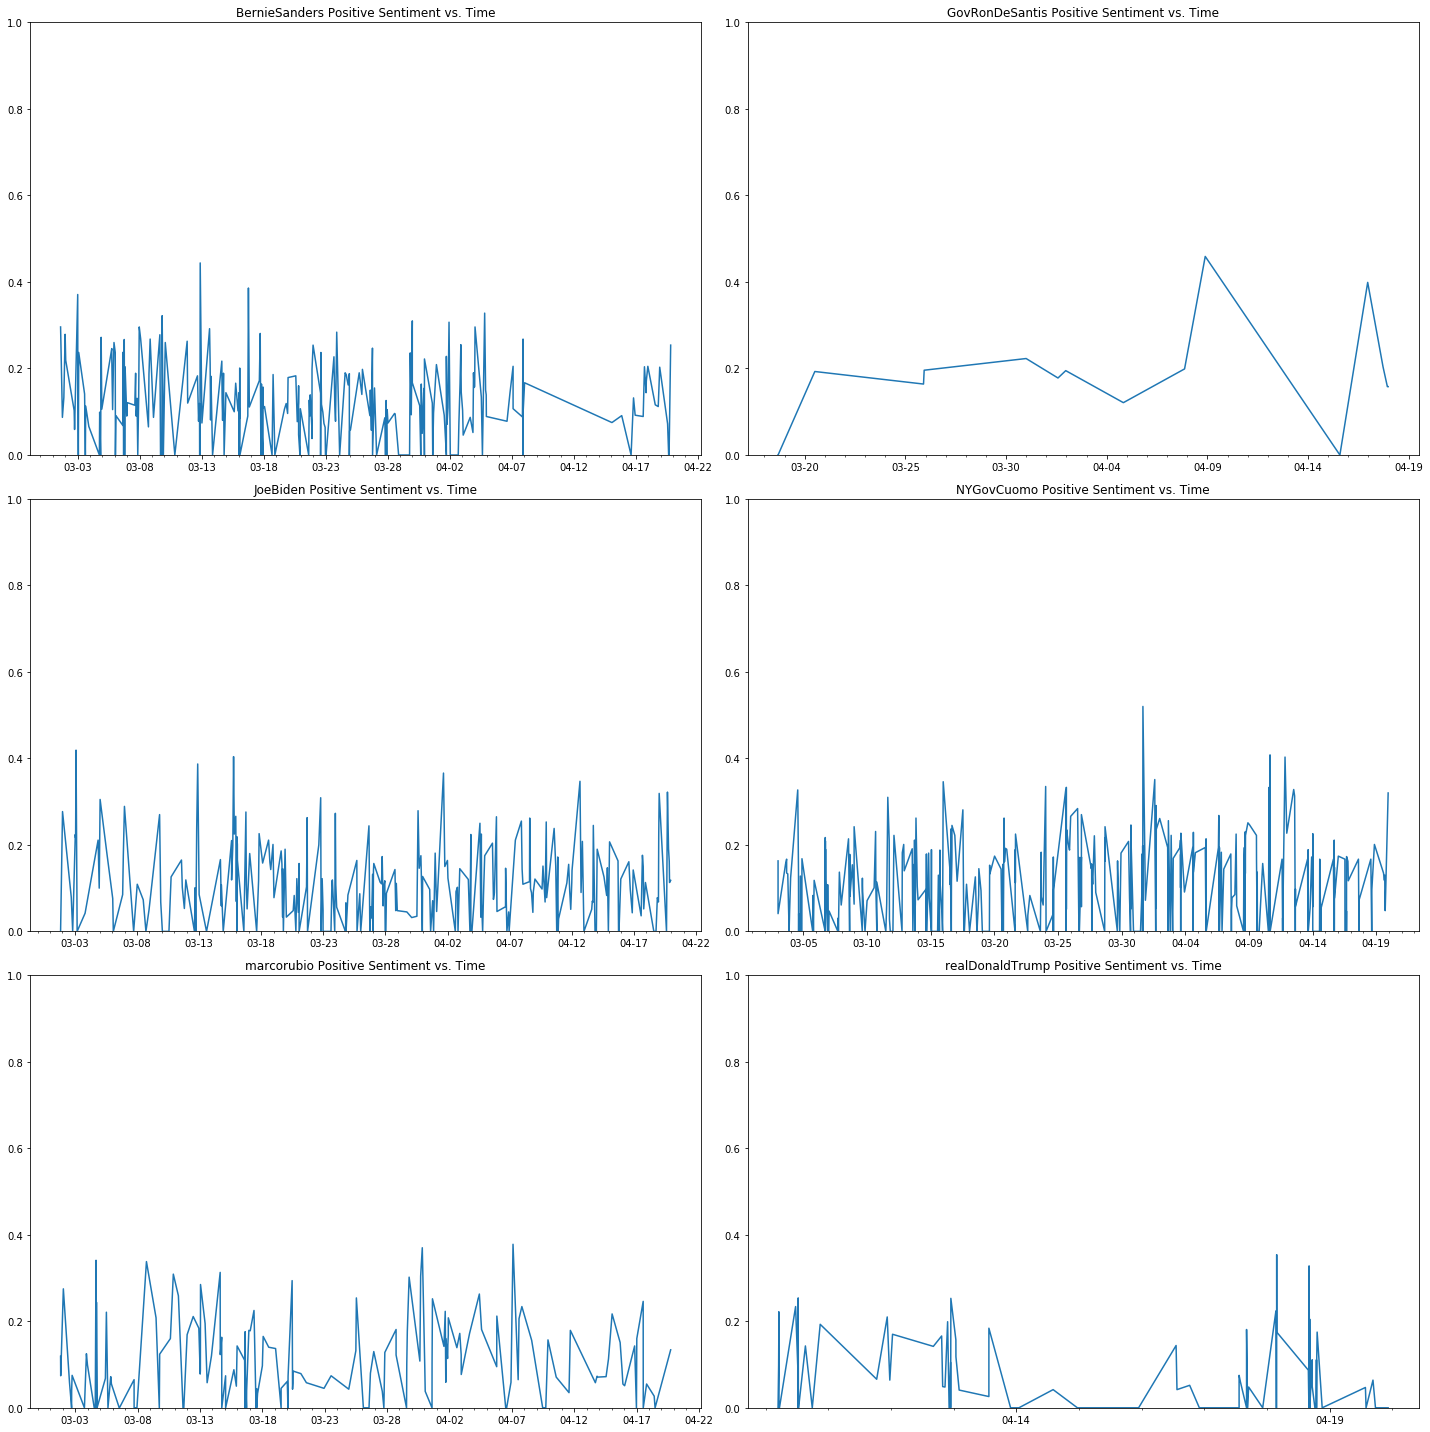

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes = axes.flatten()

for g, ax in zip(user_groups, axes):
    title = f'{g[0]} Positive Sentiment vs. Time'
    graph_sentiment(g, ax, 'pos', title=title)
    
fig.tight_layout()
fig.show()

/Users/matthewpinho/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


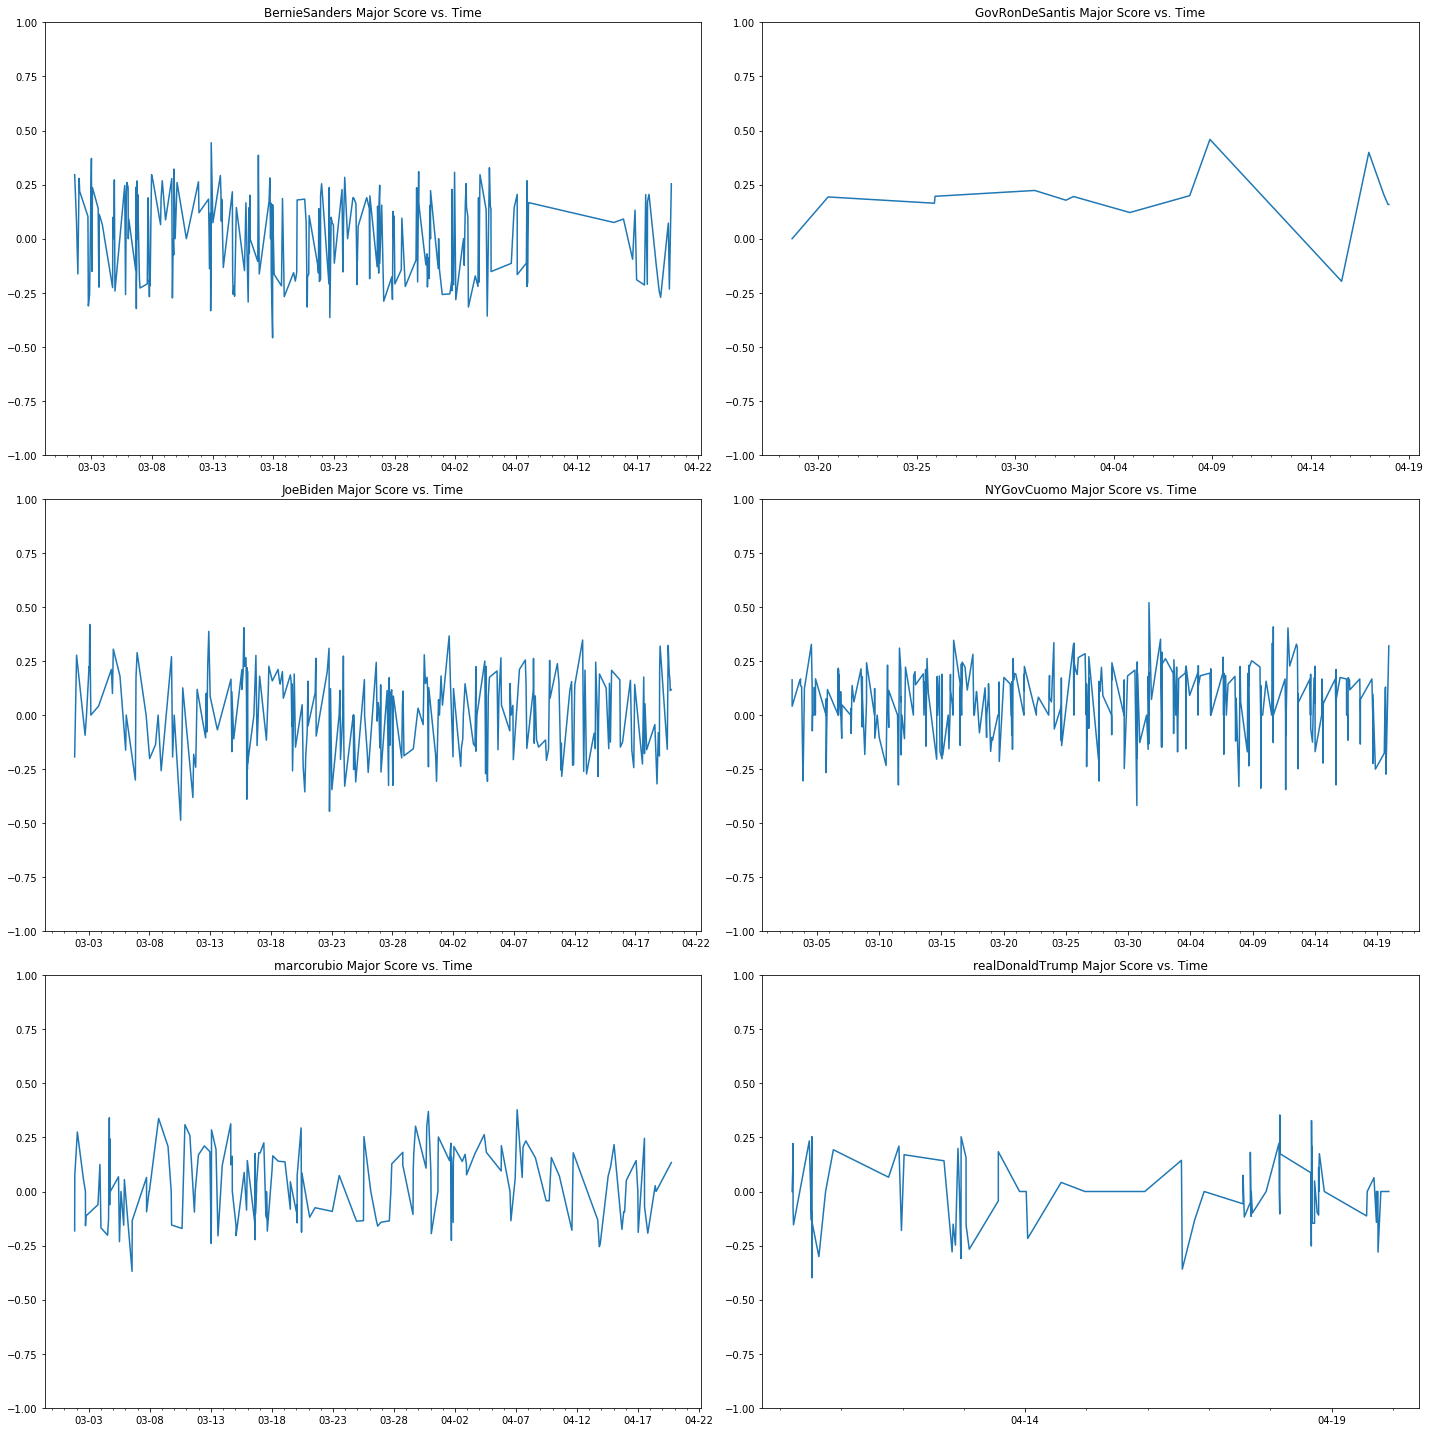

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes = axes.flatten()

for g, ax in zip(user_groups, axes):
    title = f'{g[0]} Major Score vs. Time'
    graph_sentiment(g, ax, 'major_score', ylims=(-1, 1), title=title)
    
fig.tight_layout()
fig.show()

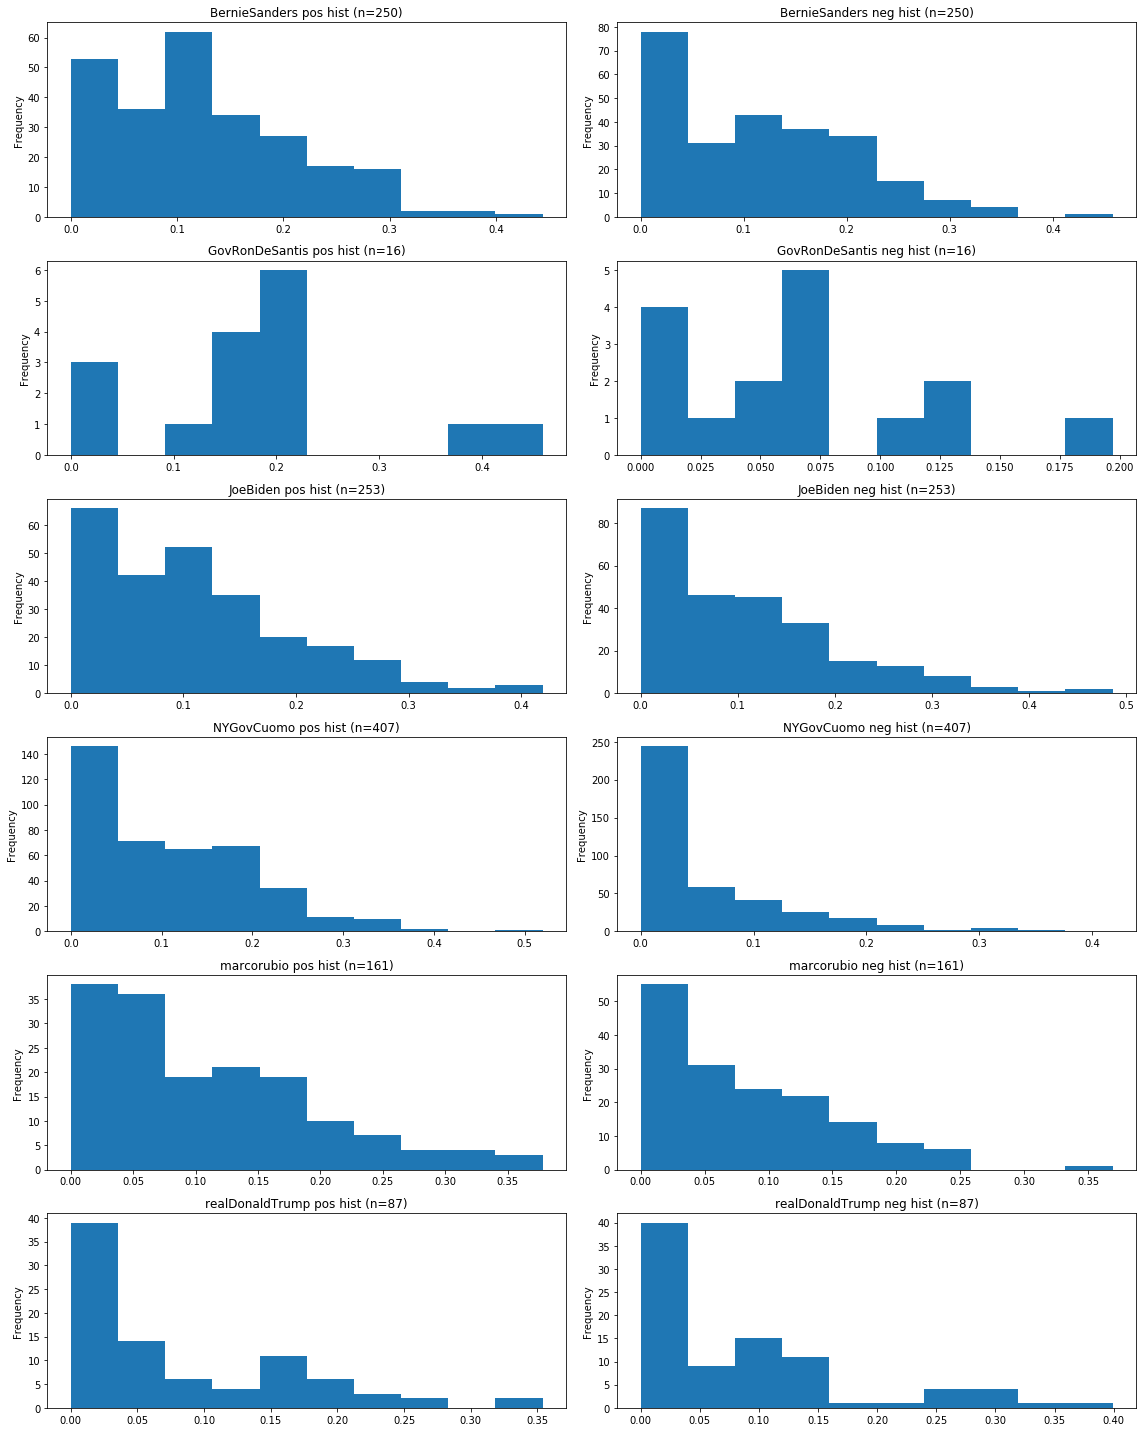

In [38]:
fig, axes = plt.subplots(6, 2, figsize=(16, 20))


for g, ax in zip(user_groups, axes):
    ax[0].set_title(f'{g[0]} pos hist (n={g[1]["pos"].shape[0]})')
    g[1]['pos'].plot(kind='hist', ax=ax[0])
    ax[1].set_title(f'{g[0]} neg hist (n={g[1]["neg"].shape[0]})')
    g[1]['neg'].plot(kind='hist', ax=ax[1])
    
plt.tight_layout()    

## Contributions
Emily Lawson: Setting up the report: topic introduction, hypotheses, conclusions

Justin Lawson: Code and explanations for data preprocessing/filtering, sentiment analysis, visualization, conclusions

Matthew Pinho: Code and explanations for data collection, writing filter keywords for preprocessing/filtering, finalizing report